# Computing saliency masks with the PAIRML saliency library (for TF2 and other frameworks)

This notebook demonstrates a number of saliency mask techniques, augmented with the `SmoothGrad` technique, using the VGG16 convolutional neural network in TF2. The intention of this notebook is to have as few dependencies as possible to show how to compute masks for ML frameowrks.

This notebook shows the following techniques, alongside with the `SmoothGrad` augmentation:

*   Vanilla Gradients
    ([paper](https://scholar.google.com/scholar?q=Visualizing+higher-layer+features+of+a+deep+network&btnG=&hl=en&as_sdt=0%2C22),
    [paper](https://arxiv.org/abs/1312.6034))
*   Integrated Gradients ([paper](https://arxiv.org/abs/1703.01365))
*   XRAI ([paper](https://arxiv.org/abs/1906.02825))
*   Grad-CAM ([paper](https://arxiv.org/abs/1610.02391))
*   Blur IG ([paper](https://arxiv.org/abs/2004.03383))
*   Guided IG ([paper](https://arxiv.org/abs/2106.09788))

This notebook assumes you have the `saliency` pip package installed. To install run (use `pip3` for python 3.x):
```
pip install saliency tensorflow
```

In [2]:
# Boilerplate imports.
import tensorflow as tf
import numpy as np
import PIL.Image
from matplotlib import pylab as P
import os,sys
os.chdir('C:/Users/daisa/プログラミング/Python/大学院卒研/test/saliency')
print(os.getcwd())

# From our repository.
import saliency.core as saliency

%matplotlib inline

C:\Users\daisa\プログラミング\Python\大学院卒研\test\saliency


### Utility methods

In [3]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im)
  P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

def ShowHeatMap(im, title, ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im, cmap='inferno')
  P.title(title)

def LoadImage(file_path):
  im = PIL.Image.open(file_path)
  im = im.resize((224,224))
  im = np.asarray(im)
  return im

def PreprocessImage(im):
  im = tf.keras.applications.vgg16.preprocess_input(im)
  return im

### Loading the VGG16 model for ImageNet

In [4]:
m = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
conv_layer = m.get_layer('block5_conv3')
model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])

`call_model_function` is how we pass inputs to our model and receive outputs necessary to computer saliency masks. The description of this method and necessary outputs is in the base CoreSaliency description, as well as separately for each method.

In [5]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

### Load an image and infer

Prediction class: 236


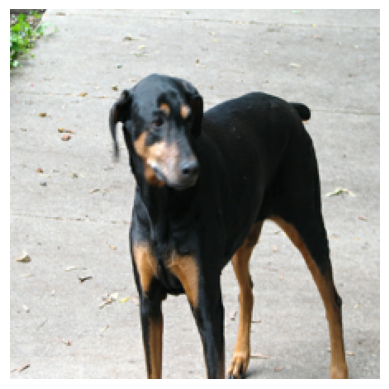

In [6]:
# Load the image
im_orig = LoadImage('./doberman.png')
im = PreprocessImage(im_orig)

# Show the image
ShowImage(im_orig)

_, predictions = model(np.array([im]))
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}

print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 236

### Vanilla Gradient & SmoothGrad

In [1]:
# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args)
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 2))

NameError: name 'saliency' is not defined

### Integrated Gradients & SmoothGrad

For saliency methods that compute gradients along a path (e.g. Integrated Gradients), we can pass a batch_size parameter, which will batch the different steps along the path together so that the model isn't called for each individual step. When using this parameter, be sure that you are not overloading memory, as a very large batch size could crash the program.

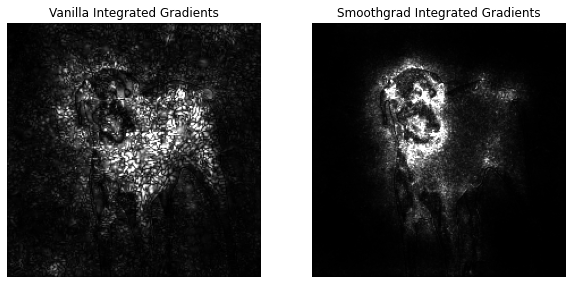

In [7]:
# Construct the saliency object. This alone doesn't do anthing.
integrated_gradients = saliency.IntegratedGradients()

# Baseline is a black image.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))

### XRAI Full and Fast

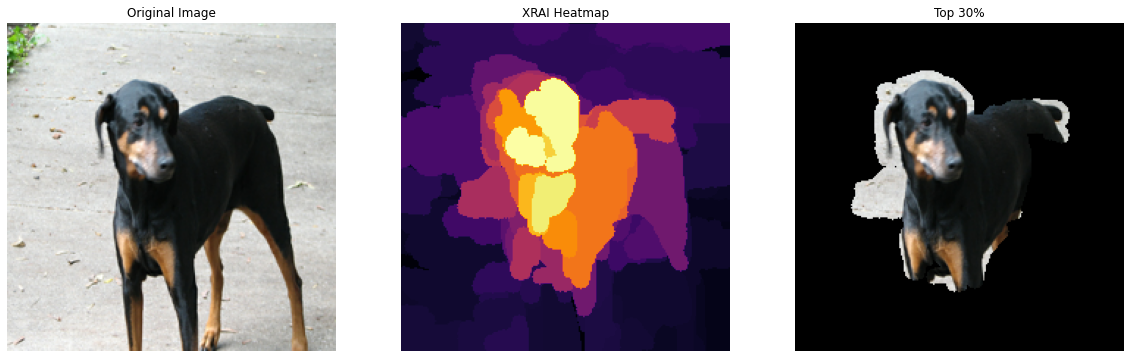

In [8]:
# Construct the saliency object. This alone doesn't do anthing.
xrai_object = saliency.XRAI()

# Compute XRAI attributions with default parameters
xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=20)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(im_orig, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions >= np.percentile(xrai_attributions, 70)
im_mask = np.array(im_orig)
im_mask[~mask] = 0
ShowImage(im_mask, title='Top 30%', ax=P.subplot(ROWS, COLS, 3))

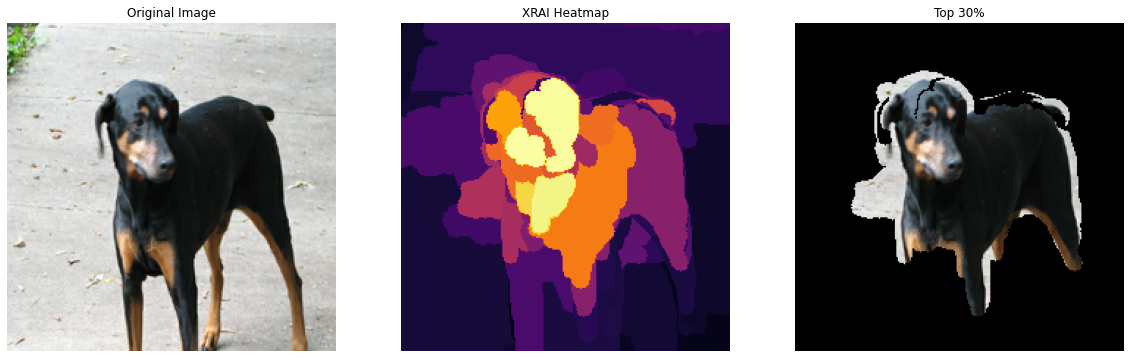

In [9]:
# Create XRAIParameters and set the algorithm to fast mode which will produce an approximate result.
xrai_params = saliency.XRAIParameters()
xrai_params.algorithm = 'fast'

# Compute XRAI attributions with fast algorithm
xrai_attributions_fast = xrai_object.GetMask(im, call_model_function, call_model_args, extra_parameters=xrai_params, batch_size=20)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(im_orig, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions_fast, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions_fast >= np.percentile(xrai_attributions_fast, 70)
im_mask = np.array(im_orig)
im_mask[~mask] = 0
ShowImage(im_mask, 'Top 30%', ax=P.subplot(ROWS, COLS, 3))

### Grad-CAM

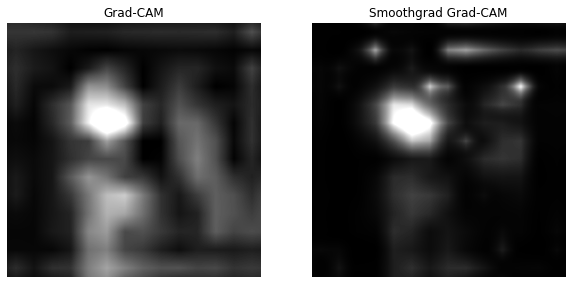

In [10]:
# Compare Grad-CAM and Smoothgrad with Grad-CAM.

# Construct the saliency object. This alone doesn't do anthing.
grad_cam = saliency.GradCam()

# Compute the Grad-CAM mask and Smoothgrad+Grad-CAM mask.
grad_cam_mask_3d = grad_cam.GetMask(im, call_model_function, call_model_args)
smooth_grad_cam_mask_3d = grad_cam.GetSmoothedMask(im, call_model_function, call_model_args)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
grad_cam_mask_grayscale = saliency.VisualizeImageGrayscale(grad_cam_mask_3d)
smooth_grad_cam_mask_grayscale = saliency.VisualizeImageGrayscale(smooth_grad_cam_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(grad_cam_mask_grayscale, title='Grad-CAM', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smooth_grad_cam_mask_grayscale, title='Smoothgrad Grad-CAM', ax=P.subplot(ROWS, COLS, 2))

### Guided IG

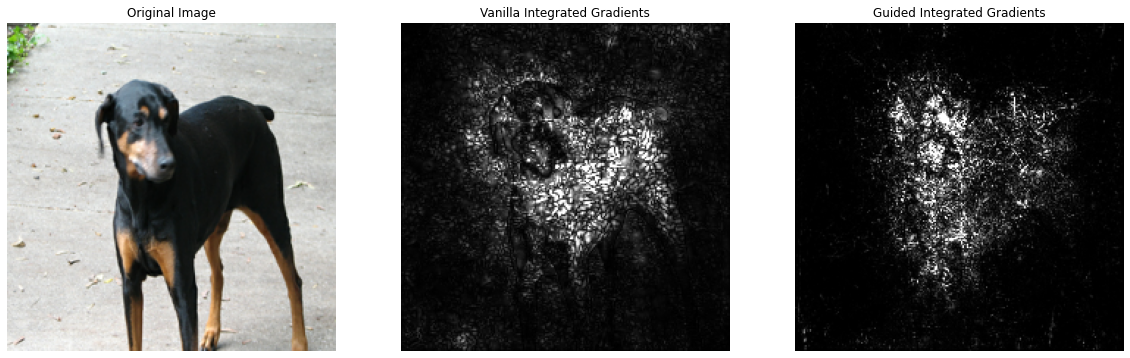

In [11]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
integrated_gradients = saliency.IntegratedGradients()
guided_ig = saliency.GuidedIG()

# Baseline is a black image for vanilla integrated gradients.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the Guided IG mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
guided_ig_mask_3d = guided_ig.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, max_dist=1.0, fraction=0.5)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
guided_ig_mask_grayscale = saliency.VisualizeImageGrayscale(guided_ig_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowImage(im_orig, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))
ShowGrayscaleImage(guided_ig_mask_grayscale, title='Guided Integrated Gradients', ax=P.subplot(ROWS, COLS, 3))

### Blur IG

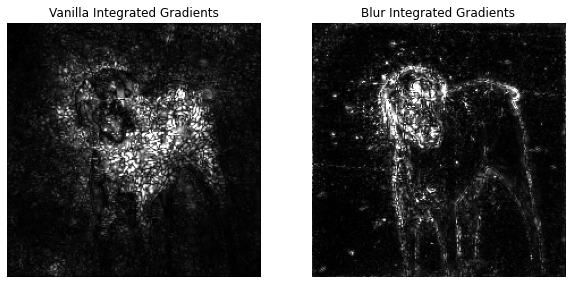

In [12]:
# Construct the saliency object. This alone doesn't do anthing.
integrated_gradients = saliency.IntegratedGradients()
blur_ig = saliency.BlurIG()

# Baseline is a black image for vanilla integrated gradients.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the Blur IG mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
blur_ig_mask_3d = blur_ig.GetMask(
  im, call_model_function, call_model_args, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(blur_ig_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(blur_ig_mask_grayscale, title='Blur Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))

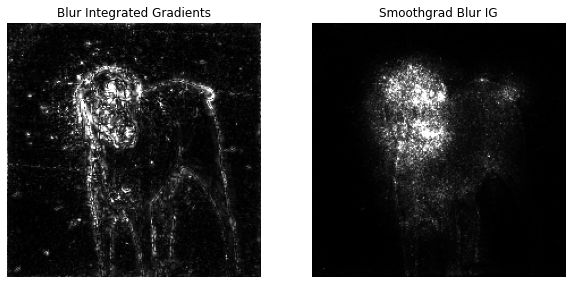

In [13]:
# Compare BlurIG and Smoothgrad with BlurIG. Note: This will take a long time to run.

# Construct the saliency object. This alone doesn't do anthing.
blur_ig = saliency.BlurIG()

# Compute the Blur IG mask and Smoothgrad+BlurIG mask.
blur_ig_mask_3d = blur_ig.GetMask(im, call_model_function, call_model_args, batch_size=20)
# Smoothed mask for BlurIG will take a while since we are doing nsamples * nsamples computations.
smooth_blur_ig_mask_3d = blur_ig.GetSmoothedMask(im, call_model_function, call_model_args, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(blur_ig_mask_3d)
smooth_blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(smooth_blur_ig_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(blur_ig_mask_grayscale, title='Blur Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smooth_blur_ig_mask_grayscale, title='Smoothgrad Blur IG', ax=P.subplot(ROWS, COLS, 2))
